# Import Libraries

In [68]:
import pandas as pd
import os
import pyomo.environ as pyo 
import numpy  as np
import matplotlib.pyplot as plt
import datetime
import gurobipy as gp
from gurobipy import GRB

# Import DF

In [69]:
Data_path_Production = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Production"
Data_path_Consumption = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Consumption"
Data_path_Users = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Users"
# Load DataFrames
DF_name = "2019_ProductionEast.csv"
DF_path = os.path.join(Data_path_Production, DF_name)
DF_East = pd.read_csv(DF_path, sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])

DF_name = "2019_ProductionSouth.csv"
DF_path = os.path.join(Data_path_Production, DF_name)
DF_South = pd.read_csv(DF_path, sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])

DF_name = "2019_ProductionWest.csv"
DF_path = os.path.join(Data_path_Production, DF_name)
DF_West = pd.read_csv(DF_path, sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])

DF_name = "2019_ConsumptionCurve.csv"
DF_path = os.path.join(Data_path_Consumption, DF_name)
DF_Consumption = pd.read_csv(DF_path, sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])

DF_name = "Thesis_User_Residential.csv"
DF_path = os.path.join(Data_path_Users, DF_name)
DF_m2_Residential = pd.read_csv(DF_path,sep=",",on_bad_lines='skip', header=0, parse_dates=[0])

DF_name = "Thesis_User_Industrial.csv"
DF_path = os.path.join(Data_path_Users, DF_name)
DF_m2_Industrial = pd.read_csv(DF_path,sep=",",on_bad_lines='skip', header=0, parse_dates=[0])

DF_name = "Thesis_User_Commercial.csv"
DF_path = os.path.join(Data_path_Users, DF_name)
DF_m2_Commercial = pd.read_csv(DF_path,sep=",",on_bad_lines='skip', header=0, parse_dates=[0])

# List of your dataframes
dataframes = [DF_South, DF_East, DF_West]

# Function to change the datetime index format
def change_datetime_index_format(df):
    df.index = df.index.astype(str)
    df.index = pd.to_datetime(df.index, format='%Y%m%d:%H%M')
    df.index = df.index.strftime('%Y%m%d %H:%M')
    df.index = pd.to_datetime(df.index, format='%Y%m%d %H:%M')
    return df

# Apply the function to each dataframe
dataframes = [change_datetime_index_format(df) for df in dataframes]

# Unpack the dataframes back to their original names if needed
DF_South, DF_East, DF_West = dataframes

# Extract the G(i) column from each DataFrame and rename it
DF_South_Gi = DF_South[['G(i)']].rename(columns={'G(i)': 'G(i)_South'})
DF_East_Gi = DF_East[['G(i)']].rename(columns={'G(i)': 'G(i)_East'})
DF_West_Gi = DF_West[['G(i)']].rename(columns={'G(i)': 'G(i)_West'})

# Combine the columns into a new DataFrame
DF_Production = pd.concat([DF_South_Gi, DF_East_Gi, DF_West_Gi], axis=1)

# Define paths to save the files
DF_Production_name_csv = "2019_Production.csv"
DF_Production_name_xlsx = "2019_Production.xlsx"
DF_path_csv = os.path.join(Data_path_Production, DF_Production_name_csv)
DF_path_xlsx = os.path.join(Data_path_Production, DF_Production_name_xlsx)

# Save the new DataFrame to CSV and Excel
DF_Production.to_csv(DF_path_csv, index=True)
DF_Production.to_excel(DF_path_xlsx, index=True)

# Save the updated DF_Consumption back to CSV with the modified index
DF_Consumption_name_csv = "2019_ConsumptionCurve.csv"
DF_path_consumption_csv = os.path.join(Data_path_Consumption, DF_Consumption_name_csv)
DF_Consumption.to_csv(DF_path_consumption_csv, index=True)

In [70]:
# Data from paper for available roof production Area
DoublePitched = 0.5 * 0.6 * 0.85 * 0.7 * 0.5
Industrial = 0.8 * 0.9 * 1 * 0.45 * 1 * 0.45 * 1
Flat = 1 * 0.6 * 0.9 * 0.45 * 0.5
costheta_Res = np.cos(20 * np.pi / 180)
costheta_Ind = np.cos(30 * np.pi / 180)
costheta_Com = np.cos(0 * np.pi / 180)
CoefRes = (DoublePitched * 0.95 + Flat * 0.05) / costheta_Res
CoefInd = Industrial / costheta_Ind
CoefCom = (Flat * 0.5 + DoublePitched * 0.5) / costheta_Com
Limit = 2
nPVLimit = 1.63 * Limit

#Change Area from string to float
DF_m2_Residential['Area'] = DF_m2_Residential['Area'].astype(str)
DF_m2_Industrial['Area'] = DF_m2_Industrial['Area'].astype(str)
DF_m2_Commercial['Area'] = DF_m2_Commercial['Area'].astype(str)

DF_m2_Residential['Area'] = DF_m2_Residential['Area'].str.replace(',', '.')
DF_m2_Industrial['Area'] = DF_m2_Industrial['Area'].str.replace(',', '.')
DF_m2_Commercial['Area'] = DF_m2_Commercial['Area'].str.replace(',', '.')

DF_m2_Residential['Area'] = DF_m2_Residential['Area'].astype(float)
DF_m2_Industrial['Area'] = DF_m2_Industrial['Area'].astype(float)
DF_m2_Commercial['Area'] = DF_m2_Commercial['Area'].astype(float)

DF_m2_Residential['Area'] = DF_m2_Residential['Area'] * CoefRes
DF_m2_Industrial['Area'] = DF_m2_Industrial['Area'] * CoefInd
DF_m2_Commercial['Area'] = DF_m2_Commercial['Area'] * CoefCom

# Delete rows where 'Area' column values are less than nPVLimit
DF_m2_Residential = DF_m2_Residential[DF_m2_Residential['Area'] >= nPVLimit]
DF_m2_Industrial = DF_m2_Industrial[DF_m2_Industrial['Area'] >= nPVLimit]
DF_m2_Commercial = DF_m2_Commercial[DF_m2_Commercial['Area'] >= nPVLimit]

# Reset the index
DF_m2_Residential = DF_m2_Residential.reset_index(drop=True)
DF_m2_Industrial = DF_m2_Industrial.reset_index(drop=True)
DF_m2_Commercial = DF_m2_Commercial.reset_index(drop=True)

In [71]:
# Function to generate random alpha values with two decimal places
def generate_alpha_columns(df):
    def round_and_adjust(row):
        row = np.round(row, 2)
        row_diff = 1.0 - row.sum()
        for i in range(len(row)):
            if row_diff == 0:
                break
            adjustment = np.round(min(row_diff, 0.01 if row_diff > 0 else -0.01), 2)
            if (row[i] + adjustment >= 0) and (row[i] + adjustment <= 1):
                row[i] += adjustment
                row_diff -= adjustment
        return row

    # Generate random values
    random_values = np.random.rand(len(df), 3)
    # Normalize the values to ensure they sum to 1
    random_values /= random_values.sum(axis=1)[:, None]
    # Round values to two decimal places and adjust to ensure they sum to 1
    adjusted_values = np.apply_along_axis(round_and_adjust, 1, random_values)
    # Create new columns
    df['S_coeff'] = adjusted_values[:, 0]
    df['W_coeff'] = adjusted_values[:, 1]
    df['E_coeff'] = adjusted_values[:, 2]
    return df

# Assuming DF_m2_Residential, DF_m2_Industrial, DF_m2_Commercial are already defined
dataframes = [DF_m2_Residential, DF_m2_Industrial, DF_m2_Commercial]

# Apply the function to each dataframe
dataframes = [generate_alpha_columns(df) for df in dataframes]

# Unpack the dataframes back to their original names if needed
DF_m2_Residential, DF_m2_Industrial, DF_m2_Commercial = dataframes

# Check the result (optional)
print(DF_m2_Residential.head())
print(DF_m2_Industrial.head())
print(DF_m2_Commercial.head())


      full_id     osm_id osm_type         Area  S_coeff  W_coeff  E_coeff
0  w158853557  158853557      way    15.215745     0.31     0.31     0.38
1  w158853558  158853558      way     8.062333     0.40     0.37     0.23
2  w158853559  158853559      way    10.943810     0.40     0.38     0.22
3  w211715359  211715359      way  1063.434159     0.48     0.07     0.45
4  w246792829  246792829      way   123.564108     0.27     0.21     0.52
   fid     full_id     osm_id        Area  S_coeff  W_coeff  E_coeff
0  414  w538115135  538115135  168.692049     0.86     0.11     0.03
1  419  w539745507  539745507   30.135606     0.07     0.62     0.31
2  420  w539745509  539745509   61.618054     0.23     0.46     0.31
3  417  w539744156  539744156   46.466073     0.46     0.05     0.49
4  418  w539744157  539744157   35.354621     0.19     0.47     0.34
      full_id     osm_id  osm_type        Area  S_coeff  W_coeff  E_coeff
0    r6994474    6994474  relation  224.034626     0.68     0.11    

In [72]:
# Calculate the production for each user
# Multiply the production DataFrame by the coefficients
user_production = (DF_Production['G(i)_South'].values[:, None] * DF_m2_Residential['S_coeff'].values +
                   DF_Production['G(i)_East'].values[:, None] * DF_m2_Residential['E_coeff'].values +
                   DF_Production['G(i)_West'].values[:, None] * DF_m2_Residential['W_coeff'].values)

# Create a DataFrame for user production
user_production_df = pd.DataFrame(user_production, index=DF_Production.index, columns=DF_m2_Residential.index)

# Example: Extract the production for the first user (assuming first row of DF_m2_Residential)
first_user_production = user_production_df.iloc[:, 0]

# Check the result (optional)
print(user_production_df.head())
print(first_user_production.head())


                     0     1     2     3     4     5     6     7     8     \
time                                                                        
2019-01-01 00:10:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2019-01-01 01:10:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2019-01-01 02:10:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2019-01-01 03:10:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2019-01-01 04:10:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                     9     ...  7827  7828  7829  7830  7831  7832  7833  \
time                       ...                                             
2019-01-01 00:10:00   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2019-01-01 01:10:00   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2019-01-01 02:10:00   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2019-01-01 03:10:00   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2019

In [73]:
# Set the maximum area constraint
Area_Res_Max = 1000000

# Define the yearlist based on the number of hours
yearlist = DF_Production.index

# Create a new Gurobi model
m = gp.Model("optimization_model_BinaryonProduction")

# Production Binary Variables [0;1]
binary_vars_production_residential = m.addVars(DF_m2_Residential.index, vtype=GRB.BINARY, name="binary_production_residential")

# Auxiliary variable for absolute deviation
deviation = m.addVars(yearlist, lb=0, vtype=GRB.CONTINUOUS, name="deviation")

# Set initial values to 1 for binary variables
for var in binary_vars_production_residential.values():
    var.start = 1

# Calculate the difference between production and consumption for each hour
difference = {
    t: gp.quicksum(binary_vars_production_residential[user] * user_production_df.loc[t, user] for user in DF_m2_Residential.index) -
       (DF_Consumption.loc[t, 'Residential'] * Area_Res_Max)
    for t in yearlist
}

# Add constraint to define the absolute value of the deviation
for t in yearlist:
    m.addConstr(deviation[t] >= difference[t], name=f"PosDeviation_{t}")
    m.addConstr(deviation[t] >= -difference[t], name=f"NegDeviation_{t}")

# Objective function: minimize the deviation
m.setObjective(gp.quicksum(deviation[t] for t in yearlist), GRB.MINIMIZE)

# Set solver parameters
m.Params.MIPGap = 0.005

# Optimize the model
m.optimize()

# Display the results
for v in m.getVars():
    print(f'{v.varName}: {v.x}')

print(f'Objective: {m.objVal}')

# Extract results
RP_values = {i: binary_vars_production_residential[i].X for i in DF_m2_Residential.index}

# Calculate total production for residential over time
total_production_residential = [
    sum(RP_values[user] * user_production_df.loc[t, user] for user in DF_m2_Residential.index)
    for t in yearlist
]

# Create a new DataFrame with the chosen binary variables
DF_m2_Residential['Chosen'] = [RP_values[user] for user in DF_m2_Residential.index]
chosen_residential = DF_m2_Residential[DF_m2_Residential['Chosen'] == 1]

# Save the results to a CSV file
results_dir = r'C:\Users\Nik\Documents\GitHub\Thesis\Results\Results_Binary'
os.makedirs(results_dir, exist_ok=True)
chosen_residential.to_csv(os.path.join(results_dir, 'chosen_residential_Test.csv'))


Set parameter MIPGap to value 0.005
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 17520 rows, 16597 columns and 66992522 nonzeros
Model fingerprint: 0xb3ebfae3
Variable types: 8760 continuous, 7837 integer (7837 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+05, 4e+06]

Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 15s
Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 22s
Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 26s
Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 30s
User MIP start produced solution with objective 1.4396e+10 (30.79s)
User MIP start p

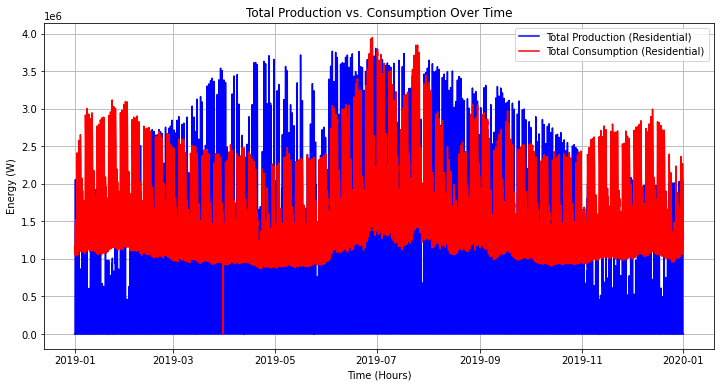

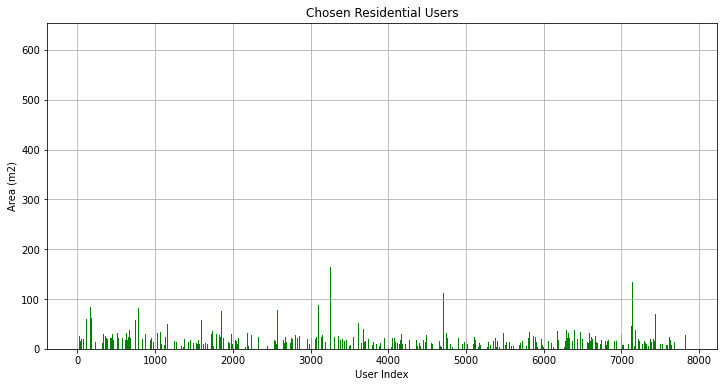

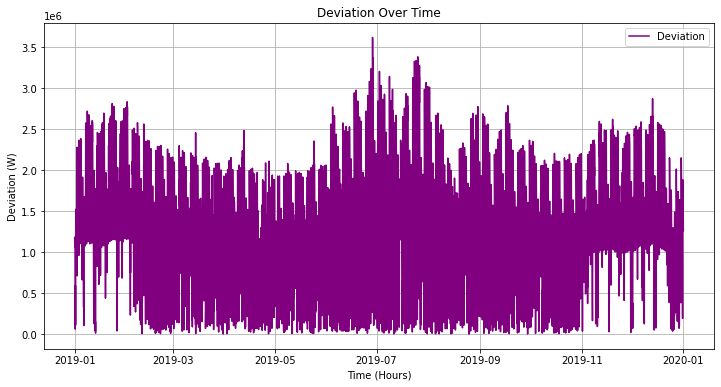

In [74]:
# Plot Total Production vs. Consumption Over Time
plt.figure(figsize=(12, 6))
plt.plot(yearlist, total_production_residential, label='Total Production (Residential)', color='blue')
plt.plot(yearlist, DF_Consumption['Residential'] * Area_Res_Max, label='Total Consumption (Residential)', color='red')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy (W)')
plt.title('Total Production vs. Consumption Over Time')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'Total_Production_vs_Consumption.png'))
plt.show()

# Plot Chosen Residential Users
chosen_users = DF_m2_Residential[DF_m2_Residential['Chosen'] == 1]
plt.figure(figsize=(12, 6))
plt.bar(chosen_users.index, chosen_users['Area'], color='green')
plt.xlabel('User Index')
plt.ylabel('Area (m2)')
plt.title('Chosen Residential Users')
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'Chosen_Residential_Users.png'))
plt.show()

# Plot Deviation Over Time
deviation_values = [deviation[t].x for t in yearlist]
plt.figure(figsize=(12, 6))
plt.plot(yearlist, deviation_values, label='Deviation', color='purple')
plt.xlabel('Time (Hours)')
plt.ylabel('Deviation (W)')
plt.title('Deviation Over Time')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'Deviation_Over_Time.png'))
plt.show()


In [75]:
# Set the maximum area constraint
Area_Res_Max = 1000000

# Define the yearlist based on the number of hours (assuming DF_Production has hourly data for a year)
yearlist = DF_Production.index

# Create a new Gurobi model
m = gp.Model("optimization_model_BinaryonProduction")

# Production Binary Variables [0;1]
binary_vars_production_residential = m.addVars(DF_m2_Residential.index, vtype=GRB.BINARY, name="binary_production_residential")

# Auxiliary variable for absolute deviation
deviation = m.addVars(yearlist, lb=0, vtype=GRB.CONTINUOUS, name="deviation")

# Set initial values to 1 for binary variables
for var in binary_vars_production_residential.values():
    var.start = 1

# Calculate the difference between production and consumption for each hour
difference = {
    t: gp.quicksum(binary_vars_production_residential[user] * user_production_df.loc[t, user] for user in DF_m2_Residential.index) -
       (DF_Consumption.loc[t, 'Residential'] * Area_Res_Max)
    for t in yearlist
}

# Add constraint to define the absolute value of the deviation
for t in yearlist:
    m.addConstr(deviation[t] >= difference[t], name=f"PosDeviation_{t}")
    m.addConstr(deviation[t] >= -difference[t], name=f"NegDeviation_{t}")

# Objective function: minimize the deviation hour by hour
m.setObjective(gp.quicksum(deviation[t] for t in yearlist), GRB.MINIMIZE)

# Set solver parameters
m.Params.MIPGap = 0.005

# Optimize the model
m.optimize()

# Display the results
for v in m.getVars():
    print(f'{v.varName}: {v.x}')

print(f'Objective: {m.objVal}')

# Extract results
RP_values = {i: binary_vars_production_residential[i].X for i in DF_m2_Residential.index}

# Calculate total production for residential over time
total_production_residential = [
    sum(RP_values[user] * user_production_df.loc[t, user] for user in DF_m2_Residential.index)
    for t in yearlist
]

# Create a new DataFrame with the chosen binary variables
DF_m2_Residential['Chosen'] = [RP_values[user] for user in DF_m2_Residential.index]
chosen_residential = DF_m2_Residential[DF_m2_Residential['Chosen'] == 1]

# Save the results to a CSV file
results_dir = r'C:\Users\Nik\Documents\GitHub\Thesis\Results\Results_Binary'
os.makedirs(results_dir, exist_ok=True)
chosen_residential.to_csv(os.path.join(results_dir, 'chosen_residential_Test2.csv'))


Set parameter MIPGap to value 0.005
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 17520 rows, 16597 columns and 66992522 nonzeros
Model fingerprint: 0xb3ebfae3
Variable types: 8760 continuous, 7837 integer (7837 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+05, 4e+06]

Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 12s
Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 21s
Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 29s
User MIP start produced solution with objective 1.4396e+10 (29.13s)
User MIP start produced solution with objective 1.4396e+10 (29.89s)
Loaded user MIP start with

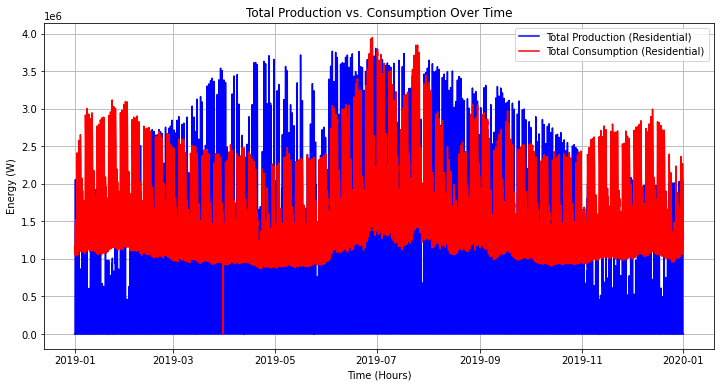

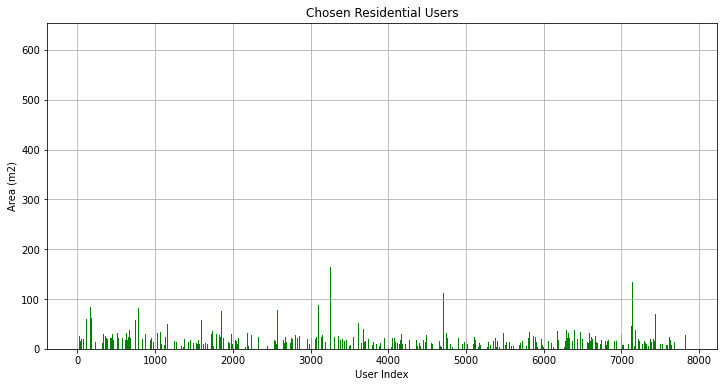

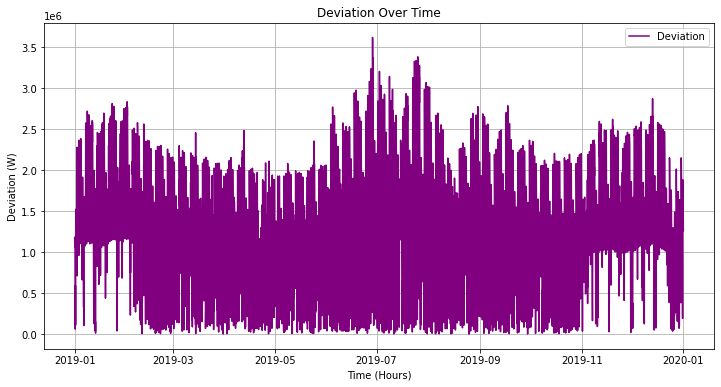

In [76]:
# Plot Total Production vs. Consumption Over Time
plt.figure(figsize=(12, 6))
plt.plot(yearlist, total_production_residential, label='Total Production (Residential)', color='blue')
plt.plot(yearlist, DF_Consumption['Residential'] * Area_Res_Max, label='Total Consumption (Residential)', color='red')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy (W)')
plt.title('Total Production vs. Consumption Over Time')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'Total_Production_vs_Consumption_Test2.png'))
plt.show()

# Plot Chosen Residential Users
chosen_users = DF_m2_Residential[DF_m2_Residential['Chosen'] == 1]
plt.figure(figsize=(12, 6))
plt.bar(chosen_users.index, chosen_users['Area'], color='green')
plt.xlabel('User Index')
plt.ylabel('Area (m2)')
plt.title('Chosen Residential Users')
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'Chosen_Residential_Users_Test2.png'))
plt.show()

# Plot Deviation Over Time
deviation_values = [deviation[t].x for t in yearlist]
plt.figure(figsize=(12, 6))
plt.plot(yearlist, deviation_values, label='Deviation', color='purple')
plt.xlabel('Time (Hours)')
plt.ylabel('Deviation (W)')
plt.title('Deviation Over Time')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'Deviation_Over_Time_Test2.png'))
plt.show()
